In [20]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.io
import scanpy.external as scex
import sklearn.metrics
import seaborn as sns
from matplotlib import pyplot as plt
import scanpyHelpers as scH
import decoupler as dc
import pdb

In [2]:
#adata=sc.read(results_file_post)
#adata.uns['log1p'] = {"base":None}

Set up out properties

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 python-igraph==0.10.4 pynndescent==0.5.12


In [4]:
%matplotlib inline

Set scanpy out-files

In [5]:
writeDir = "write/"

fileName = "LUADpdx"

resultsFile = writeDir + fileName + '.h5ad'       # final output
resultsFileQC = writeDir + fileName + '_QC.h5ad'  # post QC (pre-analysis) 

Set figure parameters

In [6]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=150, fontsize=10, format='png')
sc.settings.figdir = "figures/" + fileName + "/"
figName = fileName

In [7]:
homology = pd.read_table("data/hgncHM_121.csv", sep=",")
mouseGenes = np.array(homology["mouse"])
humanGenes = np.array(homology["human"])
homology

,mouse,human
0,A1bg,A1BG
1,A1cf,A1CF
2,A2m,A2M
3,A3galt2,A3GALT2
4,A4galt,A4GALT
...,...,...
17271,Zyg11a,ZYG11A
17272,Zyg11b,ZYG11B
17273,Zyx,ZYX
17274,Zzef1,ZZEF1


In [8]:
sigFile = "data/LUAD/humanLUADgeneSig.csv"
sigGenes = pd.read_csv(sigFile)
sigGenes

,At2-like,At1-like,HPCS,Endo-like,Adv
0,PRMT8,MAP6,SLC4A11,NEIL3,STMN2
1,TMPRSS7,AKAP5,IL23A,PRTG,KLHL1
2,VLDLR,HCK,RRAD,UPK1B,RGS17
3,LSMEM1,MRC2,TNF,KNL1,BMP7
4,NPR2,HOPX,ABTB2,CYP1B1,ZEB2
...,...,...,...,...,...
245,CHCHD10,NaN,FZD5,PARP11,AP3M2
246,SLC25A51,NaN,POGK,ADTRP,MYO10
247,IFRD1,NaN,SLC3A2,AMBRA1,STK10
248,SOCS2,NaN,UBE2D3,MCM10,EML1


In [9]:
markers = pd.DataFrame(np.empty((500*12,2), dtype="object"), columns=["genes", "clustName"])
for i,clust in enumerate(sigGenes.columns):
    for j,gene in enumerate(sigGenes.index):
        gene = sigGenes.loc[gene,clust]
        indexOver = np.where(mouseGenes == gene)[0]
        if indexOver.size > 0:
            gene = humanGenes[indexOver[0]]
        markers.iloc[i*500+j] = gene,clust
        
markers = markers.dropna()
markers

,genes,clustName
0,PRMT8,At2-like
1,TMPRSS7,At2-like
2,VLDLR,At2-like
3,LSMEM1,At2-like
4,NPR2,At2-like
...,...,...
2245,AP3M2,Adv
2246,MYO10,Adv
2247,STK10,Adv
2248,EML1,Adv


In [10]:
resultsFileQC = writeDir + fileName + '_QC.h5ad'  # post QC (pre-analysis) 
adata = sc.read(resultsFileQC)
adata

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 32487 × 14481
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_human', 'pct_counts_human', 'total_counts_mt', 'pct_counts_mt', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'PDX'

In [11]:
adata.obs.PDX.cat.categories

Index(['PDX_LX369_LX29_Ru699_LX278', 'PDX_LX55A_29A_369', 'PDX_Ru465_210_318',
       'PDX-JHU55A_Ru699_Ru890'],
      dtype='object')

In [12]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_human,pct_counts_human,total_counts_mt,pct_counts_mt,most_likely_hypothesis,cluster_feature,negative_hypothesis_probability,singlet_hypothesis_probability,doublet_hypothesis_probability,Classification,PDX
AAACCCAAGTGGTTGG-1,4740,4714,20594.0,23.293192,34.815966,46.494125,60.925512,20594.0,99.922363,842.0,4.088570,1,0,4.731754e-16,1.000000,7.359221e-13,LX29_B0254,PDX_LX369_LX29_Ru699_LX278
AAACCCACAGTAGTGG-1,4804,4788,22677.0,26.890682,37.579927,48.375006,62.287781,22677.0,99.881073,892.0,3.933501,1,0,7.898151e-14,0.996608,3.391652e-03,Ru699_B0253,PDX_LX369_LX29_Ru699_LX278
AAACCCAGTGAGAACC-1,3813,3778,10895.0,19.054612,27.443782,38.412116,54.667279,10895.0,99.926628,216.0,1.982561,1,0,2.977328e-17,1.000000,2.777294e-09,LX278-2_B0256,PDX_LX369_LX29_Ru699_LX278
AAACCCAGTTAAACAG-1,4661,4616,17594.0,22.433784,31.198136,42.008639,57.343413,17594.0,99.914818,793.0,4.507218,1,0,2.417819e-17,1.000000,2.169358e-11,LX278-1_B0255,PDX_LX369_LX29_Ru699_LX278
AAACCCATCAAGGCTT-1,4411,4367,14832.0,19.673679,28.640777,39.232740,55.191478,14832.0,99.905701,468.0,3.155340,1,0,2.254091e-17,0.999998,1.539951e-06,LX278-1_B0255,PDX_LX369_LX29_Ru699_LX278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGAGCTCC-1,5228,5078,27582.0,31.067363,40.530056,50.928142,65.212820,27582.0,99.419670,4005.0,14.520340,1,0,7.970480e-04,0.967806,3.139727e-02,Ru890_B0255,PDX-JHU55A_Ru699_Ru890
TTTGTTGGTTTCCAAG-1,6343,6279,38473.0,24.190991,34.504718,45.192733,59.059600,38473.0,99.922089,2746.0,7.137473,1,0,4.254302e-02,0.921184,3.627252e-02,Ru699_A_B0253,PDX-JHU55A_Ru699_Ru890
TTTGTTGTCGCGTGAC-1,2229,2216,9694.0,38.993192,54.456365,66.278110,78.502166,9694.0,99.476654,609.0,6.282237,1,0,3.567334e-02,0.937842,2.648504e-02,JHU55A_B_B0252,PDX-JHU55A_Ru699_Ru890
TTTGTTGTCTGTAAGC-1,2902,2889,10642.0,33.320804,46.776922,57.479797,70.043225,10642.0,99.756279,1028.0,9.659839,1,0,1.827339e-03,0.972700,2.547226e-02,JHU55A_B0251,PDX-JHU55A_Ru699_Ru890


In [13]:
#sc.pp.normalize_total(adata,target_sum=1e4)

In [14]:
#sc.pp.log1p(adata)

In [15]:
simple = []
for h in adata.obs.Classification:
    spliton = "_"
    if "-" in h:
         spliton = "-"
    simple.append(h.split(spliton)[0])
adata.obs["simpPDX"] = simple
print(np.unique(simple))

['JHU55A' 'LX278' 'LX29' 'LX29A' 'LX369' 'LX55A' 'Ru210' 'Ru318' 'Ru465'
 'Ru699' 'Ru890']


In [16]:
#pdxName = "LX55A"
#adata = adata[adata.obs.simpPDX==pdxName]

#resultsFile = writeDir + fileName + pdxName+'.h5ad'       # final output

In [17]:
def doAnalysis(adata):
    sc.pp.highly_variable_genes(adata, flavor = "seurat", n_top_genes=2000)
    adata.var["mt"] = ["MT-" in g for g in adata.var_names]
    adata.raw = adata
    adata = adata[:, np.logical_and(adata.var.highly_variable, np.logical_not(adata.var.mt))]
    sc.tl.pca(adata, n_comps = 100, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=20, n_pcs=50)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.4)    
    
    scoreNames, newBClabel, ogLabelScoreMed = scH.scoreAndLabel(adata, sigGenes, labelOfSigGenes= sigGenes.columns, ogLabel="leiden")
    
    #dc.run_ora(
    #mat=adata,
    #net=markers,
    #source='clustName',
    #target='genes',
    #min_n=3,
    #verbose=False)
    #acts = dc.get_acts(adata, obsm_key='ora_estimate')

    # We need to remove inf and set them to the maximum value observed for pvals=0
    #acts_v = acts.X.ravel()
    #max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
    #acts.X[~np.isfinite(acts.X)] = max_e
    
    #df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
    #annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
    #adata.obs['decoupler'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

    sc.pl.umap(adata, color=scoreNames+["cellState", "leiden","PDX","EPCAM","VIM","FBN1","CAPS"],ncols=4,cmap='RdBu_r')
    #adata.write(resultsFile)
    return adata

JHU55A
AnnData object with n_obs × n_vars = 4921 × 1991
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_human', 'pct_counts_human', 'total_counts_mt', 'pct_counts_mt', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'PDX', 'simpPDX', 'leiden', 'at2Score', 'at1Score', 'hpcsScore', 'endoScore', 'emtScore', 'advScore', 'cellState', 'decoupler'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt'
    uns: 'PDX_colors', 'cellState_colors', 'decoupler_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


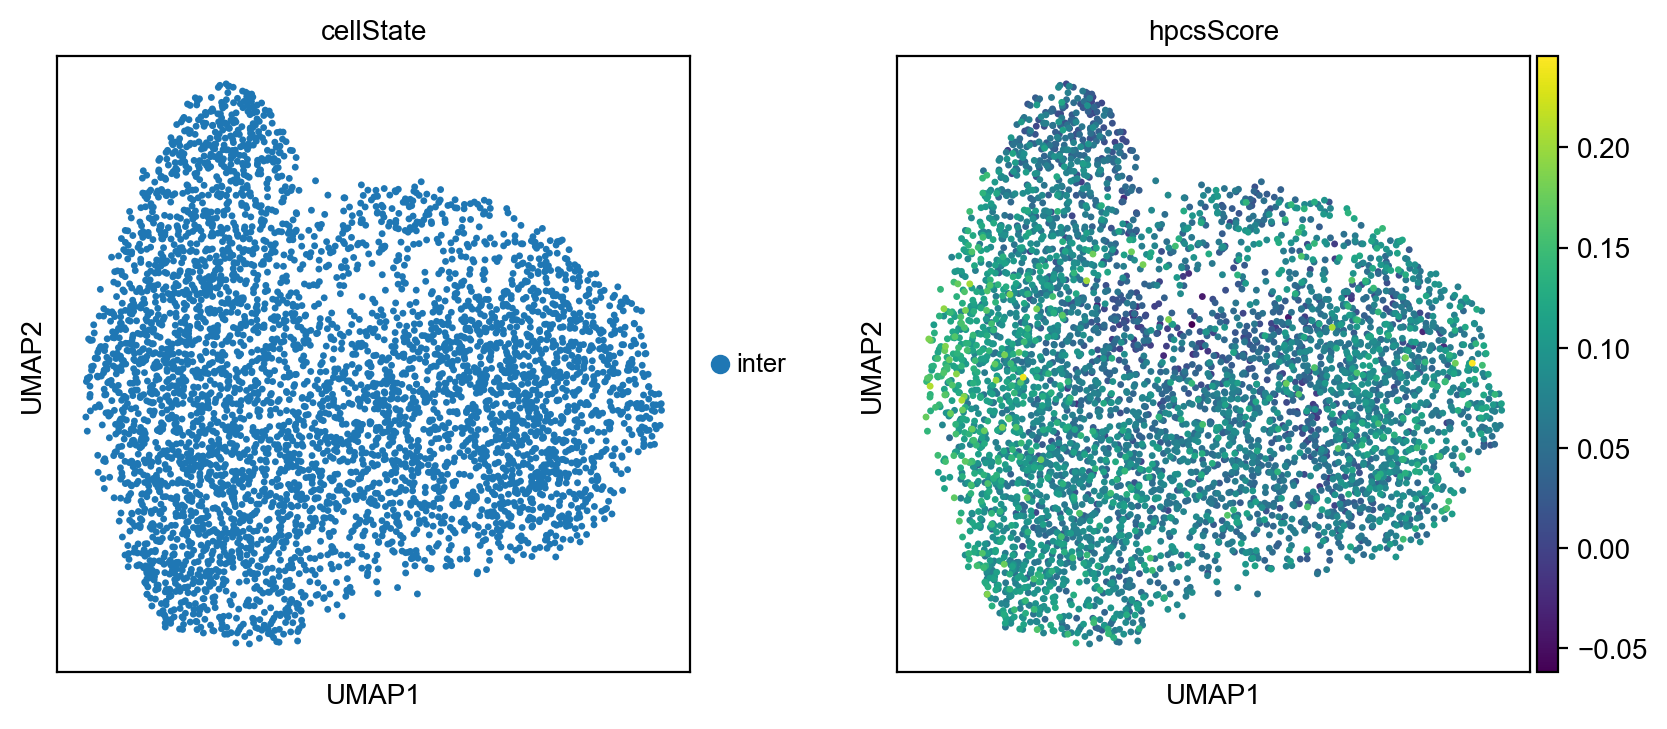

LX278
AnnData object with n_obs × n_vars = 2831 × 1996
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_human', 'pct_counts_human', 'total_counts_mt', 'pct_counts_mt', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'PDX', 'simpPDX', 'leiden', 'at2Score', 'at1Score', 'hpcsScore', 'endoScore', 'emtScore', 'advScore', 'cellState', 'decoupler'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt'
    uns: 'PDX_colors', 'cellState_colors', 'decoupler_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


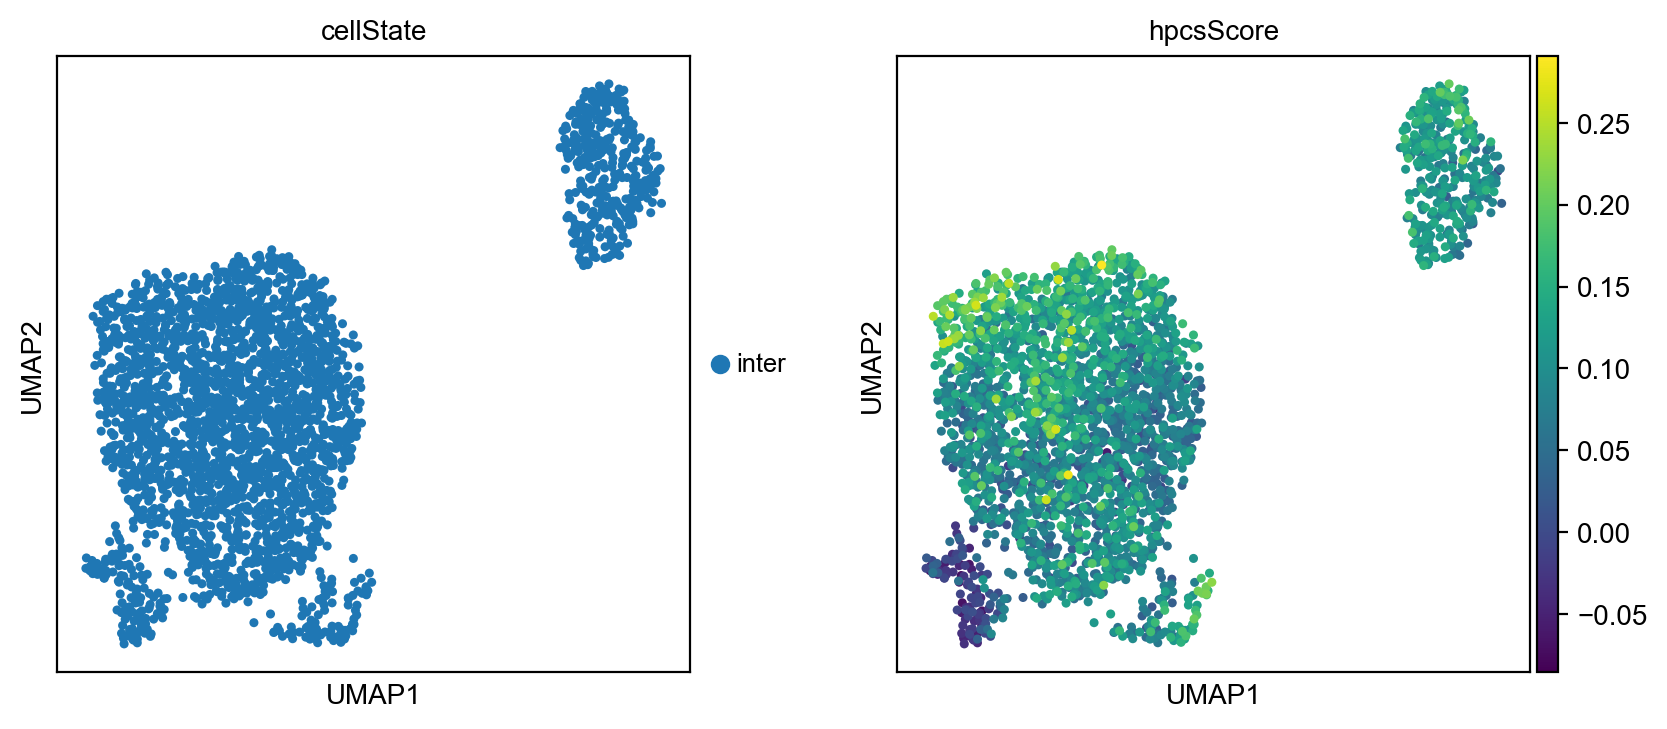

LX29
AnnData object with n_obs × n_vars = 1503 × 1996
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_human', 'pct_counts_human', 'total_counts_mt', 'pct_counts_mt', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'PDX', 'simpPDX', 'leiden', 'at2Score', 'at1Score', 'hpcsScore', 'endoScore', 'emtScore', 'advScore', 'cellState', 'decoupler'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt'
    uns: 'PDX_colors', 'cellState_colors', 'decoupler_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


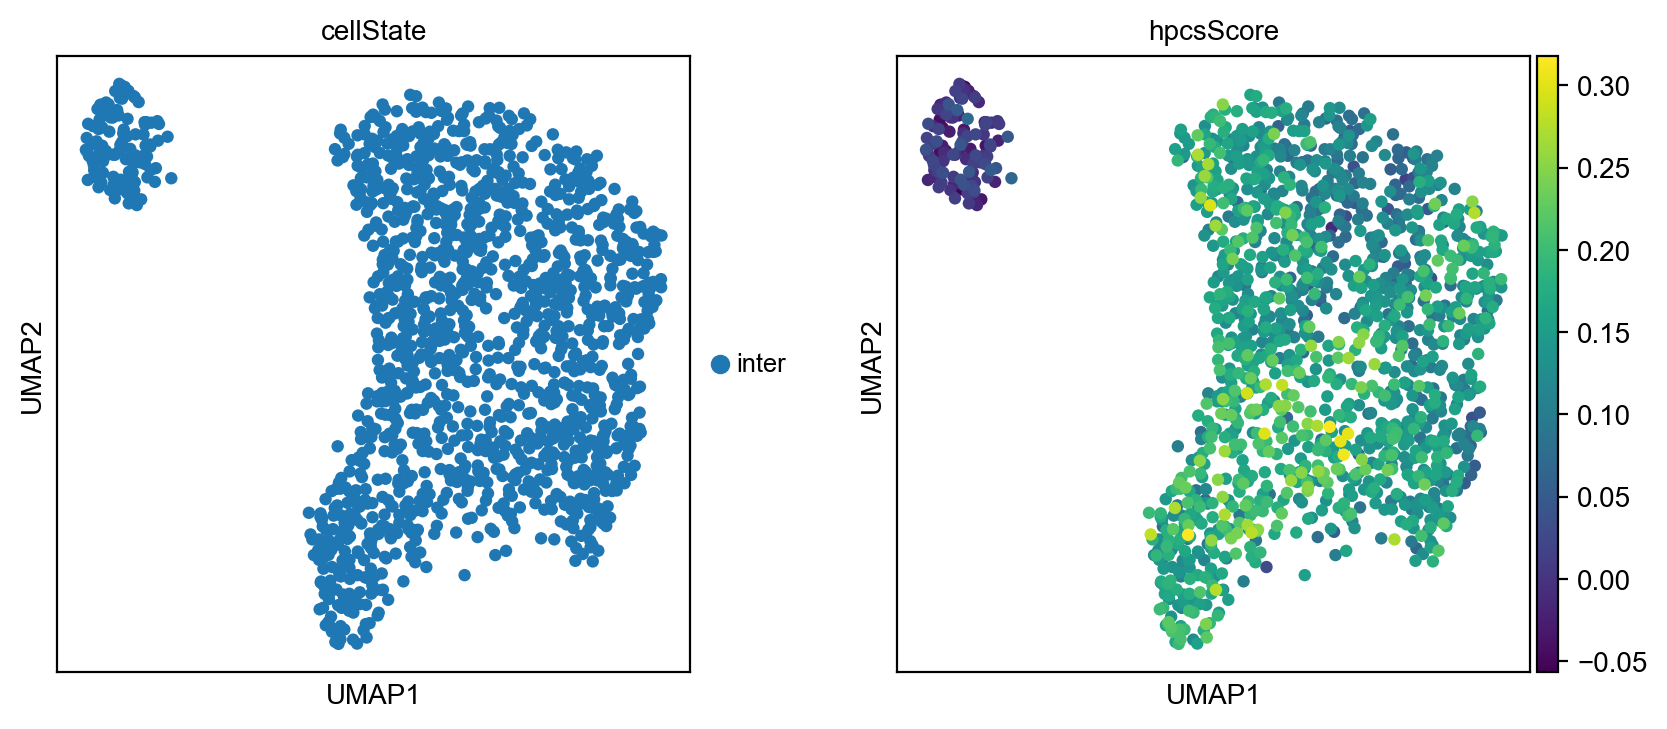

In [ ]:
for i,pdxName in enumerate(np.unique(simple)):
    adataPDX = adata[adata.obs.simpPDX==pdxName]
    resultsFile = writeDir + fileName + pdxName+'.h5ad'
    adata = sc.read_h5ad(resultsFile)
    print(pdxName)
    #scoreNames, newBClabel, ogLabelScoreMed = scH.scoreAndLabel(adata, sigGenes, labelOfSigGenes= sigGenes.columns, ogLabel="leiden")
    print(adata)
    sc.pl.umap(adata, color=["cellState","hpcsScore"])